# <center>Дипломная работа</center>

## <center>"Построение и оптимизация различных моделей Машинного Обучения для прибыльной торговли финансовыми инструментами на биржах"</center>

### Содержание:  
1. Использование API для загрузки данных.
2. Постановка задачи, включая перевод задачи регрессии в задачу классификации и EDA.
3. Определение baseline на основе только стандартных данных о курсе акций и нескольких методов классического машинного обучения.
4. Тестирование применения классических торговых индикаторов с оценкой результатов по отношению к baseline.
5. Оптимизация параметров.
6. Проверка лучших моделей и подхода на других инструментах бирж.
7. Выводы.  
8. *** Применение нейронных сетей и сравнение результатов с результатами классических методов машинного обучения (задача максимум).

In [5]:
import pandas as pd
import requests
from datetime import datetime
from tqdm import tqdm

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Использование API для загрузки данных.

In [8]:
# Тикер акции и период торговли в минутах 
ticker = 'SBER'
interval = 60

# Даты и время начала и конца периода в требуемом для API формате
start_date = '2011-11-17 10:00:00'
end_date = '2024-10-04 23:00:00'

# вспомогательный перевод данных
end_date_datetime = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

In [9]:
# загрузка данных из API Московской биржи
def download_prices(ticker, interval, start_date, end_date):
    url = f'https://iss.moex.com/iss/engines\
/stock/markets/shares/securities/{ticker}/candles.json?interval={interval}\
&from={start_date}&till={end_date}'

    # Выполнение GET-запроса
    response = requests.get(url)
    
    # Проверка успешности запроса
    if response.status_code == 200:
        data = response.json()

        columns = data['candles']['columns']
        records = data['candles']['data']
        
        df = pd.DataFrame(records, columns=columns)
        df['begin'] = pd.to_datetime(df['begin'])
        df['end'] = pd.to_datetime(df['end'])
    
    else:
        print(f"Ошибка при получении данных: {response.status_code}")
    return df

In [10]:
# начальная загрузка истории акции
df = download_prices(ticker, interval, start_date, end_date)

### Особенность API: выгрузка по 500 записей! Поэтому далее выгружаем по 500 записей и конкатенируем датафреймы

In [12]:
while df.end.max() < end_date_datetime:
    df = pd.concat([df, download_prices(ticker, interval, df.begin.max(), end_date)], axis = 0) 

In [13]:
# Поскольку последняя запись предыдущего и первая получаемых датафреймов одинаковые, то удаляем дубликаты
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36371 entries, 0 to 36370
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    36371 non-null  float64       
 1   close   36371 non-null  float64       
 2   high    36371 non-null  float64       
 3   low     36371 non-null  float64       
 4   value   36371 non-null  float64       
 5   volume  36371 non-null  int64         
 6   begin   36371 non-null  datetime64[ns]
 7   end     36371 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 2.2 MB


#### Данные включают:  
* open - стоимость инструмента в начале часа
* close - стоимость по окончанию часа
* high - максимальную цену в течение часа
* low - минимальную цену в течение часа
* value - общую стоимость оборота продаж в течение часа
* volume - общее кол-во проданных и купленных штук
* begin - время начала часа
* end - время окончания часа

In [16]:
# Удаляем одну колонку с временем как излишнюю, но и вторая колонка со временем не понадобится :-) с учётом предлагаемого подхода (смотрим дальше)
df.drop('end', axis = 1, inplace = True)

In [17]:
df.head()

,open,close,high,low,value,volume,begin
0,79.70,80.10,80.20,79.25,1.967789e+09,24613260,2011-11-17 10:00:00
1,80.10,79.84,80.40,79.63,2.103682e+09,26275650,2011-11-17 11:00:00
2,79.84,79.56,79.91,79.03,3.646895e+09,45889170,2011-11-17 12:00:00
3,79.53,79.13,79.85,78.85,2.418619e+09,30484210,2011-11-17 13:00:00
4,79.13,78.81,79.25,78.00,3.812349e+09,48524350,2011-11-17 14:00:00


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36371 entries, 0 to 36370
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    36371 non-null  float64       
 1   close   36371 non-null  float64       
 2   high    36371 non-null  float64       
 3   low     36371 non-null  float64       
 4   value   36371 non-null  float64       
 5   volume  36371 non-null  int64         
 6   begin   36371 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 1.9 MB


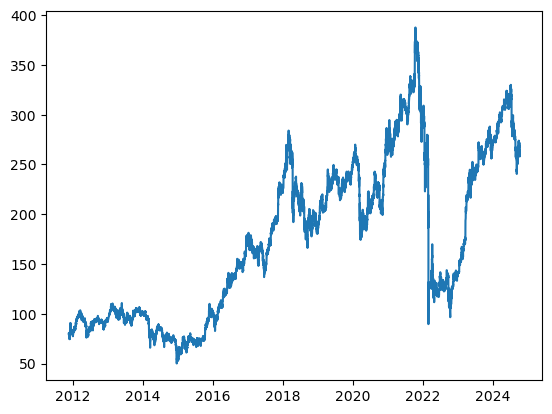

In [19]:
plt.plot(df.begin, df.close)
plt.show()

### 2. Постановка задачи, включая перевод задачи регрессии в задачу классификации и EDA.

#### В трейдинге критичным для успеха в торговле и самым сложным являются:  
* выбор момента входа в сделку (покупка или продажа актива),
* выбор момент выхода из сделки (фиксирование прибыли или незначительного убытка при выставлении stop loss).

**Прибыльность торговой стратегии определяется формулой:**  
Вероятность прибыльной сделки * Размер прибыли - Вероятность убыточной сделки * Размер убытка  

Поэтому важно, чтобы:  
* в момент входа в сделку вероятность прибыльности сделки была выше вероятности убыточной сделки
* размер прибыли от каждой сделки был, по крайней мере, не ниже размера убытка.

### Постановка задачи:  
* При помощи методов машинного обучения построить модели, когда вероятность прибыли при входе в сделку будет выше чем вероятность убытка.
* Для упрощения задачи расстояния между входом в сделку и выходом из неё (размер прибыли или убытка) считаем одинаковыми.

### Предлагаемый метод решения:  
* Свести задачу регрессии к задаче классификации, когда на исторических данных будут заранее рассчитаны классы:
  - Рост стоимости инструмента на определённый процент,
  - Падение стоимости инструмента на опреелённый процент.
* Фактом преодоления расстояния от цены покупки акции до достижения определённого расстояния будет достижение стоимостью инструмента рассчитанной заранее цены:
  - Стоимость покупки + X% (класс со значением 1) или
  - Стоимость покупки - X%т (класс со значением 0)

In [24]:
# Выбор процента роста или падения стоимости для идентификации классов
delta = 0.05
delta_max = 1 + delta
delta_min = 1 - delta

In [25]:
n_iter = df.shape[0]

# добавляем колонку со значениями классов и предварительно их размечаем как -1, которое будет заменяться на 1 и 0 при последубщих расчётах
df['result'] = -1 

In [26]:
# Расчёт достигала ли стоимость инструмента стоимости равной стоимости покупки на каждом часе +/- delta% и присвоение значений классов 1 или 0
for i in tqdm(range(0, n_iter)):
    price_close = df.iloc[i].close
    price_max = round(price_close*delta_max,2)
    price_min = round(price_close*delta_min,2)
    j = i
    while price_close > price_min and price_close < price_max and j < n_iter:
        if df.loc[j, 'low'] < price_min:
            price_close = df.loc[j, 'low']
            df.loc[i, 'result'] = 0
        elif df.loc[j, 'high'] > price_max:
            price_close = df.loc[j, 'high']
            df.loc[i, 'result'] = 1
        else:
            j+=1

100%|██████████| 36371/36371 [01:39<00:00, 364.78it/s] 


In [27]:
df.head()

,open,close,high,low,value,volume,begin,result
0,79.70,80.10,80.20,79.25,1.967789e+09,24613260,2011-11-17 10:00:00,0
1,80.10,79.84,80.40,79.63,2.103682e+09,26275650,2011-11-17 11:00:00,0
2,79.84,79.56,79.91,79.03,3.646895e+09,45889170,2011-11-17 12:00:00,0
3,79.53,79.13,79.85,78.85,2.418619e+09,30484210,2011-11-17 13:00:00,0
4,79.13,78.81,79.25,78.00,3.812349e+09,48524350,2011-11-17 14:00:00,0


In [28]:
# проверка количества значений классов в колонке result:
df['result'].value_counts()

result
 1    20677
 0    15502
-1      192
Name: count, dtype: int64

### Выводы:  
* Часть записей остались неразмеченными со значениями -1, что логично, поскольку в конце истории стоимость инструмента могла не успеть достичь рассчитанных уровней  
* Классы оказались незначительно несбалансированными (20677 и 15502), что потребует дополнительной балансировки при обучении

#### Чтобы убрать -1, просто разделим датафрейм на 2 датафрейма: 
- первый будет включать только записи до момента, когда появилось первое значение -1 и на нём будем проводить обучение,
- второй, в котором могут быть как значения -1, так и 1 и 0. Этот датафрейм оставим для последующей валидации модели, когда накопятся новые значения инструмента.

In [31]:
if not df[df['result']== -1].empty:
    df_use = df[0:df[df['result']== -1].index[0]]
    df_future_use = df[df[df['result']== -1].index[0]:]

In [32]:
# проверка количества значений классов в исследуемом датафрейме в колонке result:
df_use['result'].value_counts()

result
1    20624
0    15451
Name: count, dtype: int64

In [33]:
# проверка количества значений классов в датафрейме для последующей валидации колонке result:
df_future_use['result'].value_counts()

result
-1    192
 1     53
 0     51
Name: count, dtype: int64

In [34]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36075 entries, 0 to 36074
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   open    36075 non-null  float64       
 1   close   36075 non-null  float64       
 2   high    36075 non-null  float64       
 3   low     36075 non-null  float64       
 4   value   36075 non-null  float64       
 5   volume  36075 non-null  int64         
 6   begin   36075 non-null  datetime64[ns]
 7   result  36075 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 2.2 MB


### 3. Определение baseline на основе только стандартных данных о курсе акций и нескольких методов классического машинного обучения.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

In [37]:
# Для этой задачи классификации колонка begin для оценки baseline не понадобится. Потом можно будет использовать эту колонку для добавления новых features.
X = df_use.drop(['begin', 'result'], axis = 1)
y = df_use.result

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# Обработка несбалансированных классов с помощью SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#### Применяем Логистическую регрессию

In [42]:
lr = LogisticRegression(max_iter=2000)

In [43]:
lr.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=2000)

In [44]:
lr.score(X_train_resampled, y_train_resampled)

0.5479709267110842

In [45]:
lr.score(X_test_scaled, y_test)

0.565072765072765

In [46]:
y_pred = lr.predict(X_test_scaled)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.2f}")

# Подробный отчет о классификации
print(classification_report(y_test, y_pred))

Точность модели: 0.57
              precision    recall  f1-score   support

           0       0.49      0.46      0.48      3101
           1       0.61      0.64      0.63      4114

    accuracy                           0.57      7215
   macro avg       0.55      0.55      0.55      7215
weighted avg       0.56      0.57      0.56      7215



#### Вывод: Модель лучше предсказывает рост, чем падение инструмента (возможно, чересчур позитивна :-))

#### Применим Случайный Лес

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
# Инициализация и обучение модели Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [51]:
# Оценка точности на тестовой выборке
accuracy = rf.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.67


In [52]:
y_pred = rf.predict(X_test_scaled)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy:.2f}")

# Подробный отчет о классификации
print(classification_report(y_test, y_pred))

Точность модели: 0.67
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      3101
           1       0.72      0.69      0.70      4114

    accuracy                           0.67      7215
   macro avg       0.66      0.67      0.66      7215
weighted avg       0.67      0.67      0.67      7215



In [53]:
# Получение значимости признаков
feature_importances = rf.feature_importances_

# Создание DataFrame для визуализации значимости признаков
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

  Feature  Importance
1   close    0.180249
2    high    0.179839
3     low    0.178585
0    open    0.177716
4   value    0.142352
5  volume    0.141260


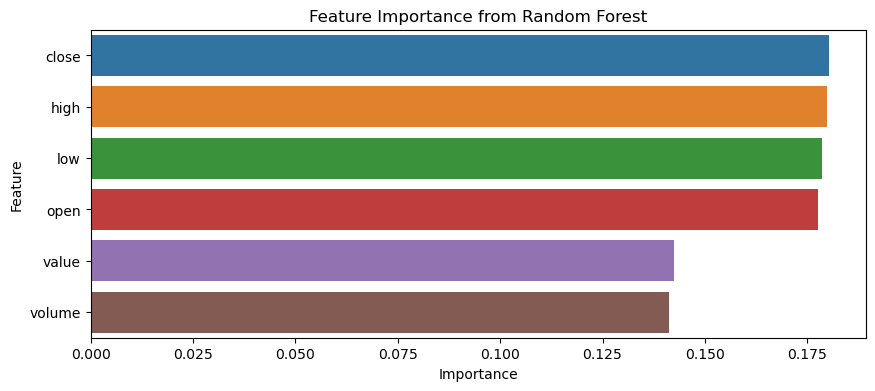

In [54]:
# Визуализация значимости признаков с помощью seaborn
plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

#### Выводы:  
* RandomForest убрал некоторую позитивность относительно роста инструментам по отношению к модели с Logistic Regression
* Факторы стоимости инструмента (цены "свечи" на открытии, закрытии, максимум и минимум) более значимы по отношению к объёму и кол-ву продаж на часовом timeframe

#### Применим Бустинг метод - XGBoost

In [57]:
from xgboost import XGBClassifier

In [58]:
# Инициализация и обучение модели XGBoost
xgb = XGBClassifier(eval_metric='mlogloss')
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [59]:
# Прогнозирование на тестовом наборе
y_pred = xgb.predict(X_test_scaled)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Подробный отчет о классификации
print(classification_report(y_test, y_pred, zero_division = 0))

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      3101
           1       0.73      0.69      0.71      4114

    accuracy                           0.68      7215
   macro avg       0.67      0.68      0.67      7215
weighted avg       0.68      0.68      0.68      7215



In [60]:
# Получение значимости признаков
importance = xgb.feature_importances_

# Создание DataFrame для визуализации значимости признаков
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

  Feature  Importance
2    high    0.313870
3     low    0.225380
1   close    0.173165
0    open    0.126760
5  volume    0.081495
4   value    0.079331


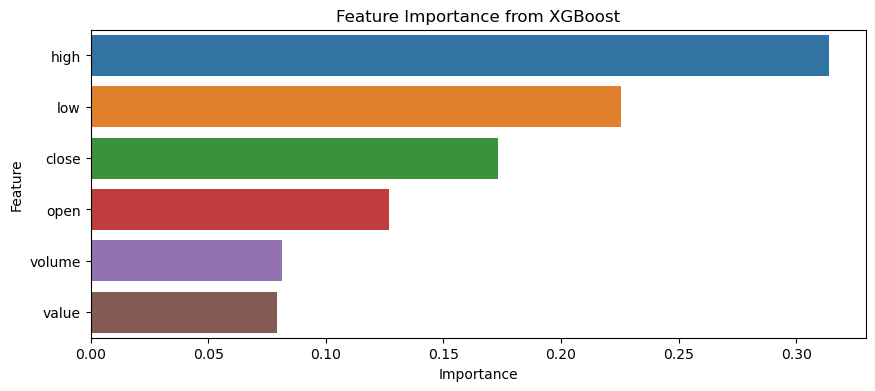

In [61]:
# Визуализация значимости признаков с помощью seaborn
plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from XGBoost')
plt.show()

#### Выводы:  
* XGBoost показал почти такие же результаты как и RandomForest
* Факторы стоимости инструмента (цены "свечи" на открытии, закрытии, максимум и минимум) также оказались более значимы по отношению к объёму и кол-ву продаж на часовом timeframe
* Максимальная стоимость инструмента на часовом timeframe оказалась самой важной.

### 4. Тестирование применения классических торговых индикаторов с оценкой результатов по отношению к baseline.